<a href="https://colab.research.google.com/github/isegura/seminarioUPM/blob/main/4_preprocessingtweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis for tweets about Covid-19

## Reading the training data

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
root='drive/My Drive/Colab Notebooks/seminarioUPM/'


In [ ]:
import pandas as pd

data_train = pd.read_csv(root+'data/Corona_train.csv', encoding="latin1")
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive


In [ ]:
print(f'Number of instances: {data_train.shape[0]}')
print(f'Number of cols: {data_train.shape[1]}')
print(f'Name of columns: {data_train.columns.values}')

Number of obs: 41156
Number of cols: 6
Name of columns: ['UserName' 'ScreenName' 'Location' 'TweetAt' 'OriginalTweet' 'Sentiment']


Text(0.5, 1.0, 'Distribution of Tweets by Sentiment Class in training dataset')

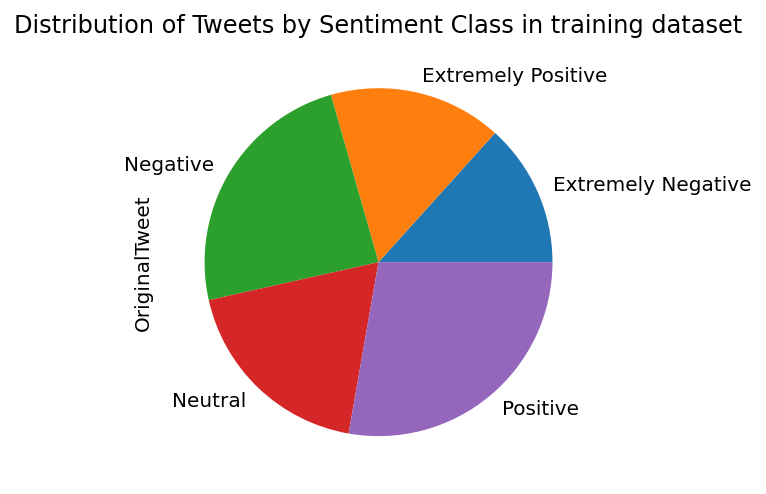

In [ ]:
# groping them by sentiment
%matplotlib inline
import matplotlib.pyplot as plt

sentiment_class = data_train['OriginalTweet'].groupby(data_train.Sentiment).count()
ax = sentiment_class.plot(kind='pie')
ax.set_title('Distribution of Tweets by Sentiment Class in training dataset')

In [ ]:
# in percentages:
sentiment_class_per = sentiment_class/data_train.shape[0]*100
print(sentiment_class_per) 

In [ ]:
ax = sentiment_class_per.plot(kind='bar')
ax.set_title('Class distribution in training set in percentages')

Some examples:

In [ ]:
# example of one tweet along with its sentiment:
data_train.iloc[5,4:6].values

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jobandtalent\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Loading dataset

In [ ]:
data_test = pd.read_csv(root+'data/Corona_test.csv', encoding="latin1")
print(f'Number of obs: {data_test.shape[0]}')
print(f'Number of cols: {data_test.shape[1]}')
print(f'Name of columns: {data_test.columns.values}')
print(f'Test to Training ratio: {data_test.shape[0]/data_train.shape[0]}')

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Text(0.5, 1.0, 'Distribution of Tweets by Sentiment Class in testing dataset')

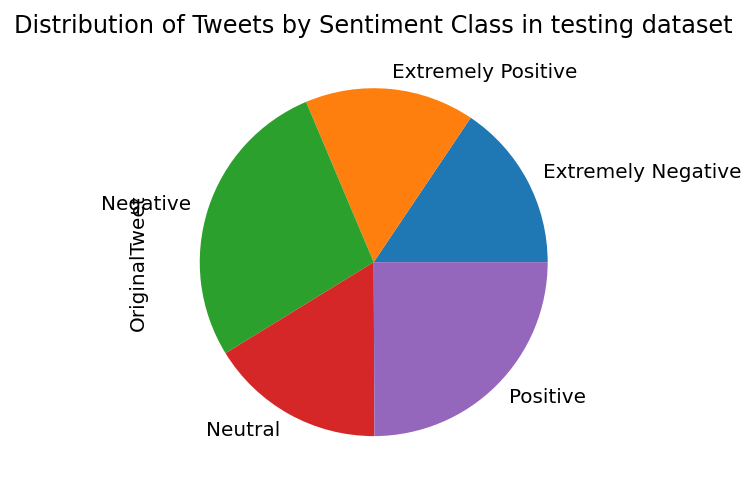

In [ ]:
sentiment_test_class = data_test['OriginalTweet'].groupby(data_test.Sentiment).count()
ax = sentiment_test_class.plot(kind='pie')
ax.set_title('Distribution of Tweets by Sentiment Class in testing dataset')

In [ ]:
# in percentages:
sentiment_test_class_per = sentiment_test_class/data_test.shape[0]*100
print(sentiment_test_class_per) 

Sentiment
Extremely Negative    15.587151
Extremely Positive    15.771459
Negative              27.409163
Neutral               16.298052
Positive              24.934176
Name: OriginalTweet, dtype: float64


In [ ]:
data = {'Training data [%]': sentiment_class_per,
        'Testing data [%]': sentiment_test_class_per}
Sent_distribution = pd.concat(data, axis=1)
Sent_distribution

,Training data [%],Testing data [%]
Sentiment,,
Extremely Negative,13.317621,15.587151
Extremely Positive,16.094859,15.771459
Negative,24.096122,27.409163
Neutral,18.738459,16.298052
Positive,27.752940,24.934176


## Preprocessing

We will deal only with the columns for the tweet and the sentiment. 

In [ ]:
train = data_train.iloc[:,4:6]
#train.head(2)
test = data_test.iloc[:,4:6]
#test.head(2)
# checking for NA values: 
print(train.isna().sum())
# NA values in testing data:
print(test.isna().sum())


## Encoding the sentiment classes

We will use encoding for the sentiment classes, so that the analysis gets easier when applying the models.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Sentiment'] = le.fit_transform(train['Sentiment'])
#train.head(2)
test['Sentiment'] = le.fit_transform(test['Sentiment'])
#test.head(2)

# transform train and test variables to numpy arrays:
train = train.to_numpy()
test = test.to_numpy()
# now we have both variables as numpy arrays
#print(type(test), type(train))

,OriginalTweet,Sentiment
0,advice Talk to your neighbours family to excha...,4
1,Coronavirus Australia: Woolworths to give elde...,4


In [ ]:
print(le.inverse_transform([0,1,2,3,4]))

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


In [ ]:
%config InlineBackend.figure_format = 'retina'

import math

# natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

import re
import string
import random


from gensim.parsing.preprocessing import remove_stopwords

C:\Users\jobandtalent\AppData\Local\Programs\Python\Python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Cleaning the data from hashtags and twitter symbols

Removing all these symbols will facilitate our analysis and make the models understand the words better.

In [ ]:
# for the training texts
def clean_texts(df):

    for i in range(0,len(df)):
        text = df[i,0]
        text = re.sub("@\S+", " ", text)      # getting rid of mentions @
        text = re.sub("https*\S+", " ", text) # getting rid of links, that can be present everywhere
        text = re.sub("#\S+", " ", text)      # getting rid of hashtags
        text = re.sub("\'\w+", '', text)      # getting rid of spaces
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # changing punctuation
        text = re.sub(r'\w*\d+\w*', '', text) # remove prefixes
        text = re.sub('\s{2,}', " ", text)    # replaces two or more spaces by only one
        text = text.lower()                   # set all text to lower letters
        text = re.sub('gt gt gt', "", text)   # removes this series of words that are for no use
        text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
        df[i,0]=text         # store the new variable 
    


In [ ]:
clean_texts(train)
clean_texts(test)

Now we will see if the texts look the way we would expect:

In [ ]:
# training
for i in range(3):
    tweet = train[random.randint(0,len(train)-1),0]
    print('-------')
    print(tweet)

-------
consumers at this time of covid most of us will prefer to shop online kindly make sure u are vigilant to be corned with this up coming apps for online shopping choose the ones with a physical address that u can locate in case of complain 
-------
pretty sure within a week or two supermarket supply chains will dry up as more counties are effected by covid and possibly go into lockdown if so would the government introduce a form of rationing so that people can eat somehow i don think so 
-------
chinese tycoons are looking to snap up global vital assets pummeled by the deadly at bargain prices the new power war post has begun as companies scramble to find a way to protect themselves 


## Removing stopwords

In [ ]:
# get all stopwords
def remove_stopwords(df)
    stop_words = set(stopwords.words('english')) 

    # for the training set:
    for i in range(0,len(df)):
        text = str(df[i,0])  # select the text in the obs. i
        text_clean = remove_stopwords(text)
        #word_tokens = word_tokenize(text_clean) 
        df[i,0] = text_clean

remove_stopwords(train)
remove_stopwords(test)


## Applying Lemmatization to further simplifying the sentences in the tweets

In [ ]:
# converting to pandas dataframe
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

train_df.columns = ['tweet', 'label']
test_df.columns = ['tweet', 'label']

In [ ]:
test_df.head()

,tweet,label
0,trending new yorkers encounter supermarket she...,0
1,couldn hand sanitizer fred meyer turned pack p...,4
2,protect loved ones,1
3,buying hits city anxious shoppers stock food a...,2
4,week buying baby milk powder buying toilet paper,3


In [ ]:
# for the training set
nltk.download('punkt')
nltk.download('wordnet')
train_df['Corpus'] = [nltk.word_tokenize(text) for text in train_df.tweet]
lemma = nltk.WordNetLemmatizer()
train_df.Corpus = train_df.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
train_df.Corpus = train_df.apply(lambda x: " ".join(x.Corpus),axis=1)

# for the testing set

test_df['Corpus'] = [nltk.word_tokenize(text) for text in test_df.tweet]
lemma = nltk.WordNetLemmatizer()
test_df.Corpus = test_df.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
test_df.Corpus = test_df.apply(lambda x: " ".join(x.Corpus),axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jobandtalent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jobandtalent\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [ ]:
# selecting only label and corpus as they are the ones we will keep
covid_train = train_df[['Corpus', 'label']]
covid_test  = test_df[['Corpus', 'label']]

In [ ]:
# no missing data
covid_train.isnull().sum(), covid_test.isnull().sum()

(Corpus    0
 label     0
 dtype: int64,
 Corpus    0
 label     0
 dtype: int64)

## Exporting preprocessed corpus of text as csv file for later analysis

In [ ]:
# creating csv for training and testing cleaned files
covid_train.to_csv(root+'data/train.csv', index=None)
covid_test.to_csv(root+'data/test.csv', index=None)